Relabeling
=======

Recall that **Variable**s in **Prove-It** are arbitrary labels that are interchangeable. In `tutorial_01_core_expr`, we demonstrated using the `relabeled` method of **Expression** to transform an expression to one with **Variable**s swapped for other **Variable**s.  This was, however, only a transformation of the expression with no proof implication.  Here we will discuss the *relabeling* derivation step in which we can derive a new **KnownTruth** from an existing **KnownTruth** by swapping **Variable**s for other **Variable**s.

### Attempting to relabel a free Variable of an assumption

Let us take an example from the previous tutorial notebook:

In [1]:
from proveit import Implies # actually defined in proveit.logic.boolean.boolOps.py
from proveit.common import A, B, C
A_impl_B = Implies(A, B)
A_impl_B # Expression meaning "A implies B":

In [2]:
B_from_A = A_impl_B.deriveConsequent(assumptions={A, A_impl_B})
B_from_A

Now we will attempt to perform a relabeling derivation step by calling the `relabel` method on a **KnownTruth**.  This will not work because we are not allowed to relabel a **Variable** in the list of assumptions.  Otherwise we would end up being able to prove false statements (unless we relabeled the assumptions in a consistent manner, but **Prove-It** has a different mechanism for doing this as we shall see next).

In [3]:
from proveit.common import C
from proveit import RelabelingFailure
try:
    B_from_A.relabel({B:C})
except RelabelingFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Proof step failed assuming {A, A => B}: Cannot relabel using assumptions that involve any of the relabeling variables


### Convert 'implicit' assumptions to 'explicit' hypotheses

If we convert the assumptions to explicit hypotheses first, then we can do the relabeling that we failed to do before.

In [4]:
explicit_B_from_A = B_from_A.asImplication(A_impl_B).asImplication(A)
explicit_B_from_A

This is a true statement that requires no assumptions.  This statement is valid for any value of $A$ and $B$ according to the rule that an implication is true as long as the conclusion is true whenever the hypothesis is true (but otherwise being indifferent to truth-aptness).  Now we will relabel $B$ to $C$ by calling **KnownTruth**'s `relabel` method.

In [5]:
explicit_C_from_A = explicit_B_from_A.relabel({B:C})
explicit_C_from_A

Here is the full proof:

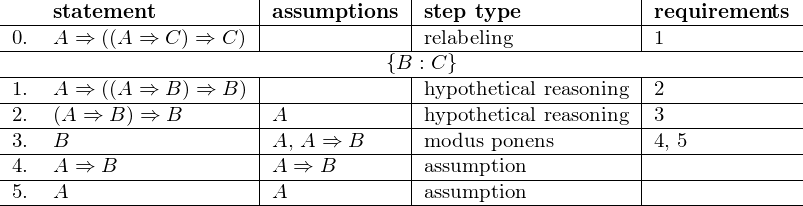

In [6]:
explicit_C_from_A.proof()

### Simultaneous relabeling

Relabeling will occur simultaneously in a consistent manner.  For example, we can switch labels.

In [7]:
explicit_B_from_A.relabel({A:B, B:A})

Let us try a case with three labels that we will cycle.

In [8]:
nestedImpl = Implies(A, Implies(B, C))
nestedImpl

In [9]:
CfromNestedImpl = nestedImpl.deriveConsequent([nestedImpl, A]).deriveConsequent([nestedImpl, A, B])
CfromNestedImpl

In [10]:
cascadingImpl = CfromNestedImpl.asImplication(nestedImpl).asImplication(B).asImplication(A)
cascadingImpl

Convincing yourself that this is correct is left as an exercise to the reader (you could make a truth table and/or check the logic that got us to this point).  In any case, now we will demonstrate cyclic relabeling.

In [11]:
relabeledCascadingImpl = cascadingImpl.relabel({A:B, B:C, C:A})
relabeledCascadingImpl

Let us look at this proof:

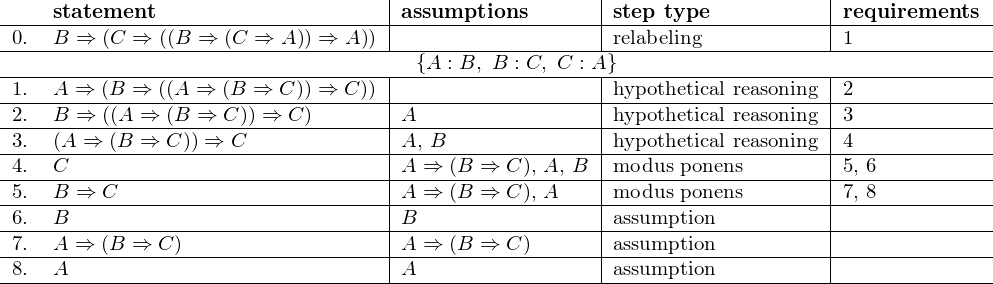

In [12]:
relabeledCascadingImpl.proof()

### Duplicated relabeling

It is possible to relabel multiple **Variable**s to the same **Variable** to derive a **KnownTruth** that is weaker than the original statement.

In [13]:
redundantCascadingImpl = cascadingImpl.relabel({A:B})
redundantCascadingImpl

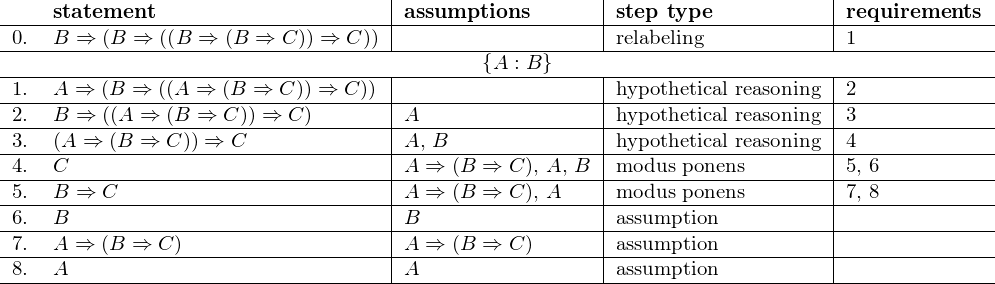

In [14]:
redundantCascadingImpl.proof()

### Literals cannot be relabeled

We saw that **Literal**s cannot be relabeled in *expression relabeling* in `tutorial01_core_expr`.  Let us revisit this and verify that we cannot perform a relabeling derivation step.

In [15]:
from proveit import Literal
X = Literal('tutorial', 'X')
Y = Literal('tutorial', 'Y')
Z = Literal('tutorial', 'Z')

In [16]:
XYZimpl = Implies(X, Implies(Y, Z))
XYZimpl

Let us try to relabel this.  Our first mistake will be that the expression is not a **KnownTruth**.  **Expression** has a `relabeled` method, but to call `relabel` (and make an actual derivation step), we need to start with a **KnownTruth**.

In [17]:
from proveit import RelabelingFailure
try:
    XYZimpl.relabel({Y:C})
except AttributeError as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Implies instance has no attribute 'relabel'


Let us make this an axiom to make it a **KnownTruth** by fiat.  This is not normally how axioms are created, but we will get into that in a later tutorial

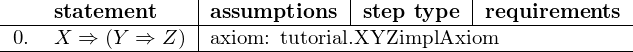

In [18]:
from proveit import Axiom
XYZimplAxiom = Axiom(XYZimpl, 'tutorial', 'XYZimplAxiom')
XYZimplAxiom

Now we will try to `relabel`:

In [19]:
from proveit import RelabelingFailure
try:
    XYZimplAxiom.provenTruth.relabel({Y:C})
except RelabelingFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Proof step failed: May only relabel a Variable or a MultiVariable


That time, we got the error message that only **Variable**s, or **MultiVariables**, may be relabeled.  We will demonstrated **MultiVariable** relabeling later in this tutorial.

### Scoping violation

We also noted with *expression relabeling* in `tutorial01_core_expr` that we are not allowed to violate the scoping restrictions of **Lambda** expressions.  We will revisit this for the case of the *relabeling* derivation step.

For our examples, we will invoke the infinite geometic series theorem from `proveit.number.summation`:

In [20]:
from proveit.number.summation._theorems_ import infGeomSum

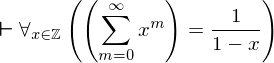

In [21]:
infGeomSum

Let us look how this expression is deconstructed in the expression information.  Note the use of **Lambda** mappings for the `Forall` *instance expression* and the `Sum` *summand*.  These **Lambda** mappings define new scopes for $x$ and $m$ respectively.

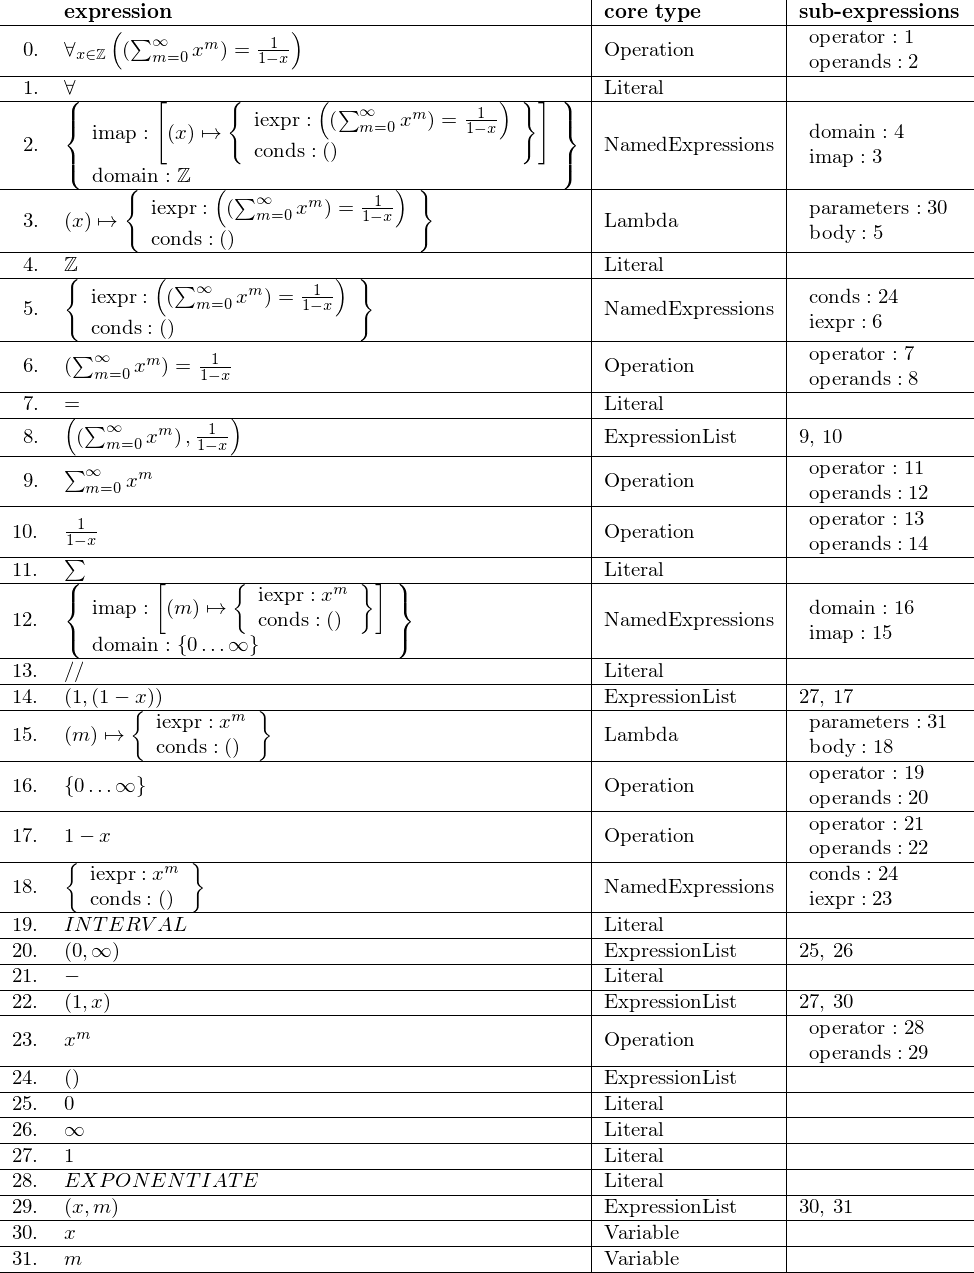

In [22]:
infGeomSum.exprInfo()

Now we will use relabeling on the geometric series theorem to prove that we can write it in terms of $a$ and $n$ instead of $x$ and $m$.

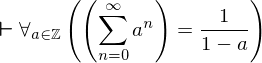

In [23]:
from proveit.common import a, n, m, x
infGeomSum.relabel({x:a, m:n})

We can also swap the labels.

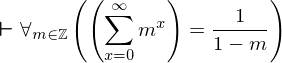

In [24]:
from proveit.common import a, n, m, x
infGeomSum.relabel({x:m, m:x})

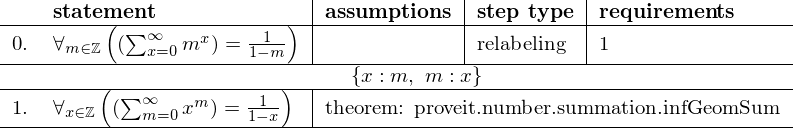

In [25]:
infGeomSum.relabel({x:m, m:x}).proof()

However, we are subject to **Lambda** scoping restrictions if we try to relabel in any manner such that they map to the same **Variable** (or the meaning could be changed in a manner that is not strictly weaker).

In [26]:
from proveit import ScopingViolation
from proveit.common import m, x
try:
    infGeomSum.relabel({m:x})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Relabeling in violation of Variable scoping restrictions.


In [27]:
try:
    infGeomSum.relabeled({x:m})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Relabeling in violation of Variable scoping restrictions.


In [28]:
try:
    infGeomSum.relabeled({x:n, m:n})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Relabeling in violation of Variable scoping restrictions.
